这里会展示 GMM 的两个案例:

1. 演示 EM Algorithm 求解 GMM 中参数, 其中假设方差是已知的.

2. 同时也会演示 GMM 中的 Singularity 问题, 其中假设方差是待估计的.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

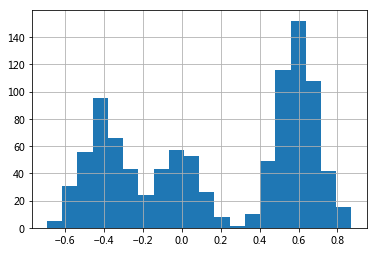

In [2]:
# 原始数据
cluster_data = pd.read_csv("./cluster_data.csv")
data = cluster_data["data"]
data_labels = cluster_data["label"]

_=data.hist(bins=20)

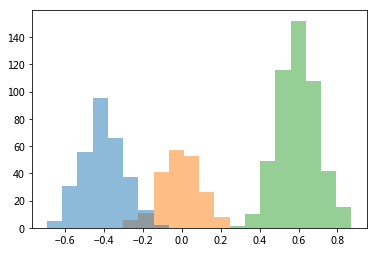

In [3]:
def plot_clusters(data_points, data_assigns):
    gby = pd.DataFrame({
            'data': data_points, 
            'assignment': data_assigns}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

# 真实的 cluster label下绘制的直方图
plot_clusters(data, data_labels)

### 使用 EM Algorithm 求解 GMM

现假设方差已知 $\sigma^2 = 0.01$

观测到的数据为 $ x_1, x_2, ..., x_n $, 相应的隐含类别为 $ z_1, ..., z_n $.

待估计的参数为 $\theta = (\alpha_1, ..., \alpha_K, u_1, ..., u_K)$, 其中 $K$ 为 cluster 的数目.

EM Algorithm 的迭代公式如下:

- **E-step**:

$$ p(z_i|x_i, \theta^{old}) = \frac{\alpha_{z_{i}}N(x_{i}|u_{z_{i}}, \sigma^2)}{\sum_{l=1}^{k}\alpha_{l}N(x_{i}|u_{l}, \sigma^2) } $$

- **M-step**:

$$ \alpha_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})}{n} $$
    
$$ u_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old}) x_{j}} {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})} $$

In [4]:
from scipy.stats import dirichlet, norm

class GMM:
    
    def __init__(self, n_clusters=3, variance=0.01):
        self.n_clusters = n_clusters
        self.variance = variance
        self.std = np.sqrt(self.variance)
        
        self.means = norm().rvs(n_clusters)
        self.alphas = dirichlet([1] * n_clusters).rvs(1)[0]

    def fit(self, data, num_epoches=100):
        data_size = data.shape[0]
        std = np.sqrt(self.variance)

        responsibility = np.zeros_like([data_size, self.n_clusters])
        for i_epoch in range(num_epoches):
            # e-step
            responsibility = np.array([self.calc_prob(data[data_i]) for data_i in range(data_size)])
            responsibility = np.divide(responsibility, responsibility.sum(axis=1)[:, np.newaxis])

            # m-step
            responsibility_sum = responsibility.sum(axis=0)
            self.alphas = responsibility_sum / data_size
            self.means = (responsibility * data.values[:, np.newaxis]).sum(axis=0) / responsibility_sum        

    def calc_prob(self, data_point):
        probs = np.array([norm.pdf(data_point, loc=self.means[cluster_i], scale=self.std) for cluster_i in range(self.n_clusters)])
        return probs

    def predict_pdf(self, data_point):
        probs = self.calc_prob(data_point)
        return np.sum(probs * self.alphas)
    
    def predict_prob(self, data_point):
        probs = self.calc_prob(data_point)
        return np.divide(probs, probs.sum())

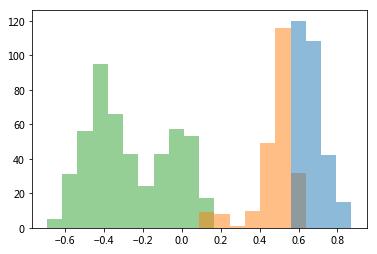

In [5]:
gmm = GMM()
gmm.fit(data)

# 使用 em 求解出来的数据的直方图
data_assigns = [gmm.predict_prob(data_point=data_item).argmax() for data_item in data]
plot_clusters(data, data_assigns)

### GMM 中的 Singularity 问题

关于 GMM 中的 Singularity 问题详细说明可以参考 **PRML Chapter 09 Mixtures of Gaussians Page 434**

>GMM 中 singularity 出现的原因:
>
>The main point here is that when fitting a single Gaussian, all the data points have to share one set of parameters μ,σ, unlike in the mixture case where one component can "focus" on one data point without penalty to the overall data likelihood.


**这里假设方差是未知的，以演示GMM中的Singularity现象**

观测到的数据为 $ x_1, x_2, ..., x_n $, 相应的隐含类别为 $ z_1, ..., z_n $.

待估计的参数为 $\theta = (\alpha_1, ..., \alpha_K, u_1, ..., u_K, \sigma_1, ..., \sigma_K)$, 其中 $K$ 为 cluster 的数目.

EM Algorithm 的迭代公式如下:

- **E-step**:

$$ p(z_i|x_i, \theta^{old}) = \frac{\alpha_{z_{i}}N(x_{i}|u_{z_{i}}, \sigma_{z_i}^2)}{\sum_{l=1}^{k}\alpha_{l}N(x_{i}|u_{l}, \sigma_l^2) } $$

- **M-step**:

$$ \alpha_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})}{n} $$
    
$$ u_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old}) x_{j}} {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})} $$

$$\sigma_l = \frac{\sum_{j=1}^{n} p(l | x_j, \theta^{old}) (x_j-u_{z_j})^2}{\sum_{j=1}^{n} p(l | x_j, \theta^{old})}$$

下面的代码和前面类似.
为了演示 GMM 中可能的 Singularity 的问题, 这里做了一些修改.
1. 假设方差未知, M-step 中会对方差求估计值
2. 用于测试的数据点重新构造了. 总数据量更小, 不同成分的数据量偏差更大.
3. EM 算法当中, 一开始就初始化某个mean为某个数据点, 其初始 std 设置的很小

从最后的结果可以看到 log_likelihood 在迭代过程中会趋向于 infinity, 出现了所谓的 Singularity 问题.

In [6]:
from scipy.stats import dirichlet, norm

class GMM_Singularity:
    
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        
        self.means = norm().rvs(n_clusters)
        self.alphas = dirichlet([1] * n_clusters).rvs(1)[0]
        self.stds = np.abs(norm().rvs(n_clusters))

    def fit(self, data, num_epoches=100):
        data_size = data.shape[0]

        # 初始化某个mean为某个数据点, 其初始 std 设置的很小
        self.means = np.array([min(data.values), 0, 1])
        self.stds = np.array([0.01, 1, 1])
        responsibility = np.zeros_like([data_size, self.n_clusters])
        for i_epoch in range(num_epoches):
            print("-------------step: %d" % i_epoch)
            print("means:", self.means, "stds:", self.stds, "alphas:", self.alphas)
            # log_likelihood = np.sum([np.log(self.calc_prob(data[data_i])) for data_i in range(data_size)])
            print("log_likelihood:", np.sum([np.log(self.predict_pdf(data[data_i])) for data_i in range(data_size)]))

            # e-step
            responsibility = np.array([self.calc_prob(data[data_i]) for data_i in range(data_size)])
            responsibility = np.divide(responsibility, responsibility.sum(axis=1)[:, np.newaxis])

            # m-step
            responsibility_sum = responsibility.sum(axis=0)
            self.alphas = responsibility_sum / data_size
            self.means = (responsibility * data.values[:, np.newaxis]).sum(axis=0) / responsibility_sum
            # 更新方差的估计值.
            self.stds = np.sqrt((responsibility * np.square(data.values[:, np.newaxis] - self.means)).sum(axis=0) / responsibility_sum)

            
    def calc_prob(self, data_point):
        probs = np.array([norm.pdf(data_point, loc=self.means[cluster_i], scale=self.stds[cluster_i]) for cluster_i in range(self.n_clusters)])
        return probs

    def predict_pdf(self, data_point):
        probs = self.calc_prob(data_point)
        return np.sum(probs * self.alphas)
    
    def predict_prob(self, data_point):
        probs = self.calc_prob(data_point)
        return np.divide(probs, probs.sum())

In [7]:
def gen_samples():
    num_per_component = [2, 9, 9]
    mean_per_component = [-2, 0, 2]
    std_per_component = [1, 1, 1]
    samples = []
    for i in range(3):
        samples.extend(norm(loc=mean_per_component[i], scale=std_per_component[i]).rvs(num_per_component[i]))
    return pd.Series(samples)

samples = gen_samples()
samples.head()

0    0.221076
1   -1.960514
2   -1.196659
3    0.541954
4   -1.431141
dtype: float64

In [8]:
gmm_singularity = GMM_Singularity()
gmm_singularity.fit(samples, num_epoches=5)

# 使用 em 求解出来的数据的直方图
data_assigns = [gmm_singularity.predict_prob(data_point=data_item).argmax() for data_item in data]
# plot_clusters(data, data_assigns)

-------------step: 0
means: [-1.96051409  0.          1.        ] stds: [0.01 1.   1.  ] alphas: [0.1295831  0.01002037 0.86039653]
log_likelihood: -36.90812134200699
-------------step: 1
means: [-1.96051409  0.08088072  1.63851552] stds: [7.87323923e-19 1.34010846e+00 1.05015604e+00] alphas: [0.04992071 0.37577885 0.57430044]
log_likelihood: 4.1525319722027705
-------------step: 2
means: [-1.96051409  0.17720756  1.75029492] stds: [0.         1.37855869 0.92739349] alphas: [0.05       0.43941061 0.51058939]
log_likelihood: nan
-------------step: 3
means: [nan nan nan] stds: [nan nan nan] alphas: [nan nan nan]
log_likelihood: nan
-------------step: 4
means: [nan nan nan] stds: [nan nan nan] alphas: [nan nan nan]
log_likelihood: nan


/home/nlp/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/nlp/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
